In [12]:
import numpy as np
import random
import math

city_list = [
    "New York", "Los Angeles", "Chicago", "Houston", "Phoenix",
    "Philadelphia", "San Antonio", "San Diego", "Dallas", "San Jose",
    "Austin", "Jacksonville", "Fort Worth", "Columbus", "Charlotte",
    "San Francisco", "Indianapolis", "Seattle", "Denver", "Washington"
]

def generate_random_city_links(cities: list, oriented = True):
    """
    Generate a random adjacency matrix

    Parameters
    ----------
    cities : list
        a list of city names that will represent each vertex
        
    oriented : bool, optional
        Whether or not the graph should be oriented. If True, the graph is oriented 
        (the adjacency matrix is not necessarily symmetrical). Default is True.

    Returns
    -------
    type : list
        a random adjacency matrix
    """
    
    adjacency_matrix = []

    if (oriented):
        for i in range(len(cities)):
            adjacency_matrix.append([random.randint(0, 1) if i != j else 0 for j in range(len(cities))])
        return adjacency_matrix
    
    for i in range(len(cities)):
        
        adjacency_matrix.append(
                [adjacency_matrix[j][i] for j in range(i)] +
                [0] +
                [random.randint(0, 1) if i != j else 0 for j in range(len(cities) - i - 1)]
        )
        
    return adjacency_matrix

random_cities_adjacency_matrix = generate_random_city_links(city_list)
np.array(random_cities_adjacency_matrix)

for random_cities_adjacency_matrix_line in random_cities_adjacency_matrix:
    print(random_cities_adjacency_matrix_line)



[0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0]
[1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0]
[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0]
[1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1]
[1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0]
[0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1]
[1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1]
[1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0]
[1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0]
[1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0]
[0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1]
[0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1]
[1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]
[0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]
[1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1]
[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
[1, 0, 1, 0, 0, 0, 1, 1,

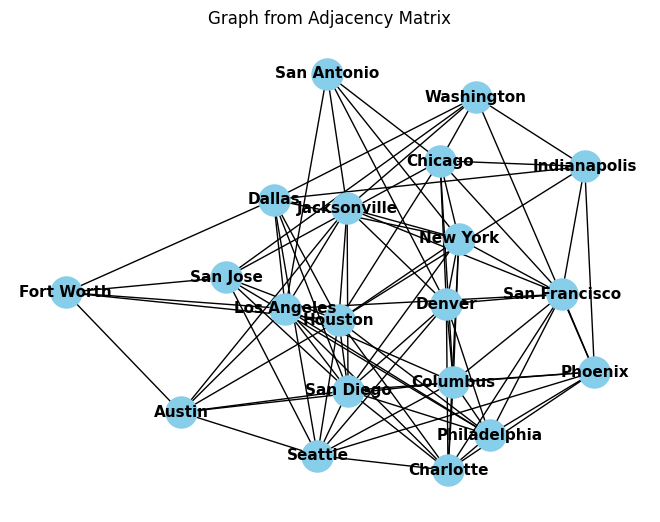

In [37]:
import networkx as nx
import matplotlib.pyplot as plt

def create_graph(vertices, adjacency_matrix):
    G = nx.Graph()

    # Add vertices to the graph
    for vertex in vertices:
        G.add_node(vertex)

    # Add edges to the graph based on the adjacency matrix
    num_vertices = len(vertices)
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if adjacency_matrix[i][j] == 1:
                G.add_edge(vertices[i], vertices[j])
    
    return G

def draw_graph(G):
    
    pos = nx.spring_layout(G)  # Positions nodes using Fruchterman-Reingold force-directed algorithm
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=11, font_weight='bold')
    plt.title("Graph from Adjacency Matrix")
    plt.show()
    
G = create_graph(city_list, random_cities_adjacency_matrix)

draw_graph(G)    

In [22]:
def is_connected(graph):
    """
    Check if a graph is connected using depth-first search (DFS).

    Parameters:
    graph (nx.Graph): The graph object.

    Returns:
    bool: True if the graph is connected, False otherwise.
    """
    # Perform DFS traversal starting from an arbitrary node
    visited = set()
    start_node = next(iter(graph.nodes()))  # Get the first node in the graph
    dfs(graph, start_node, visited)

    # Check if all nodes have been visited
    return len(visited) == len(graph.nodes())

def dfs(graph, node, visited):
    """
    Perform depth-first search (DFS) traversal on the graph.

    Parameters:
    graph (nx.Graph): The graph object.
    node: The current node in the traversal.
    visited (set): A set to track visited nodes.

    Returns:
    None
    """
    visited.add(node)
    for neighbor in graph.neighbors(node):
        if neighbor not in visited:
            dfs(graph, neighbor, visited)

print("Is the graph connected?", is_connected(G))

Is the graph connected? True


In [13]:
def find_random_solution(adjacency_matrix):
    unique_cities = len(adjacency_matrix[0])
    unique_cities_visited = []
    chain = []

    departure_city = random.choice(range(0, unique_cities))
    current_city = departure_city
    
    chain.append(departure_city)

    # 
    
    while (len(unique_cities_visited) != unique_cities):
        
        linked_cities = [index for index, value in enumerate(adjacency_matrix[current_city]) if value == 1]
        
        if not linked_cities:
            raise ValueError("No linked city...")
            
        random_linked_city = get_random_linked_city(linked_cities, unique_cities_visited)
        
        if (random_linked_city not in unique_cities_visited):
            unique_cities_visited.append(random_linked_city)
                
        current_city = random_linked_city
        chain.append(current_city)
        
        
    while (True):
        
        linked_cities = [index for index, value in enumerate(adjacency_matrix[current_city]) if value == 1]

        if not linked_cities:
            raise ValueError("No linked city...")
        
        if departure_city in linked_cities:
            chain.append(departure_city)
            break
        
        random_linked_city = random.choice(linked_cities)
        current_city = random_linked_city
        chain.append(current_city)
        
    return chain

def get_random_linked_city(linked_cities: list, unique_cities_visited: list):
    
    linked_cities_to_chose_from = linked_cities
    random_linked_city = 0
    
    for i in range(len(linked_cities)):
            
        random_linked_city = random.choice(linked_cities_to_chose_from)
        linked_cities_to_chose_from.remove(random_linked_city)
        
        if (random_linked_city not in unique_cities_visited):
            return random_linked_city

    return random_linked_city

random_solution = find_random_solution(random_cities_adjacency_matrix)
print(random_solution)
print(len(random_solution))

[5, 12, 7, 10, 18, 0, 11, 1, 2, 16, 17, 13, 5, 15, 4, 6, 19, 14, 9, 3, 8, 5]
22


In [ ]:
def decay_law(alpha: float):
    return 0.99 * alpha

def get_neighbourhood(adjacency_matrix: list, current_city: int):
    neighbourhood = [index for index, value in enumerate(adjacency_matrix[current_city]) if value == 1]
    return neighbourhood
    
def pertubate(solution: list, city_list: list):
    
    perturbated_solution = solution[:]
    tested_tuples = []
    
    while True:
        
        i, j = random.sample(range(len(perturbated_solution)), 2)
        
        if (i, j) not in tested_tuples:
            tested_tuples.append((i, j))
            
            # Picking 2 random cities to swap
            neighbourhood_intersection = list(set([perturbated_solution[i - 1], perturbated_solution[i + 1]]) & set(get_neighbourhood(random_cities_adjacency_matrix, j)))
            
            # Checking if the 2 picked cities can be swapped
            if len(neighbourhood_intersection) == 2:
                
                perturbated_solution[i], perturbated_solution[j] = perturbated_solution[j], perturbated_solution[i]
                break

#def simulated_annealing(decay_law: callable, s0: list, adjacency_matrix: list, cost_matrix):
    